In [237]:
# Charity Smith
# Diving into Darkness: A Comparative Analysis of Batman Movies Through NLP and Sentiment Analysis

In [238]:
# Importing necessary libraries
import pdfplumber
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import seaborn as sns
from wordcloud import WordCloud
from nltk import pos_tag
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from transformers import pipeline
from textblob import TextBlob
from wordcloud import WordCloud

In [239]:
# File paths for the two Batman movie scripts
pdf_files = {
    'Batman': '/Users/charitysmith/Documents/MSDS629_Practicum/Batman_SamHamm.pdf',
    'The Dark Knight': '/Users/charitysmith/Documents/MSDS629_Practicum/TheDarkKnight.pdf'
}

In [240]:
# Function to extract text from PDF
def extract_text_from_pdf(pdf_path):
    with pdfplumber.open(pdf_path) as pdf:
        text = ''
        for page in pdf.pages:
            text += page.extract_text()
    return text

# Extracting text from each PDF and storing it in a dictionary
scripts = {}
for movie, pdf_path in pdf_files.items():
    scripts[movie] = extract_text_from_pdf(pdf_path)

In [241]:
# Checking the extracted text (first 500 characters of each script)
for movie, script in scripts.items():
    print(f"--- {movie} ---")
    print(script[:500])
    print("\n")

--- Batman ---
BATMAN
Screenplay by
Sam Hamm
Based on the Character Created by
Bob Kane
FIRST DRAFT
October 20, 1986
FADE IN:
EXT. CITYSCAPE - NIGHT
The place is Gotham City. The time, 1987 -- once removed.
The city of Tomorrow: stark angles, creeping shadows,
dense, crowded, airless, a random tangle of steel and
concrete, self-generating, almost subterranean in its
aspect... as if hell had erupted through the sidewalks and
kept on growing. A dangling fat moon shines overhead, ready
to burst.
EXT. CATHEDRAL - 


--- The Dark Knight ---
THE DARK KNIGHT
by
Jonathan Nolan and Christopher Nolan
Story by
Christopher Nolan & David S. Goyer
Batman created by
Bob KaneT H E D A R K K N I G H T
BURNING. Massive flames. A dark shape emerges- The BAT
SYMBOL. Growing. Filling the screen with BLACKNESS.
CUT TO:
DAYLIGHT. Moving over the towers of downtown Gotham...
Closing in on an office building... On a large window...
Which SHATTERS to reveal-
INT. OFFICE, HIGH RISE -- DAY
A man in a CLOWN MASK h

In [242]:
# Read and process each script
processed_scripts = {}
for movie, script_text in scripts.items():
    processed_scripts[movie] = script_text

In [243]:
# Define stopwords
stop_words = set(stopwords.words('english'))

# Custom list of additional stopwords to remove
custom_stopwords = ['continue', 'continued', 'hes', 'stopwords', 'one', 'looks', 'like', 'gilc', 'ifteeb', 'youre','your','turns','dont','know','back','behind']

# Combine NLTK stopwords with custom stopwords
all_stopwords = stop_words.union(custom_stopwords)

In [244]:
def remove_non_dialogue(text):
    # Define patterns for non-dialogue text to be removed
    non_dialogue_patterns = [
        r'^INT\..*',            # Lines starting with INT.
        r'^EXT\..*',            # Lines starting with EXT.
        r'^ANGLE.*',            # Lines starting with ANGLE
        r'^ANOTHER ANGLE.*',    # Lines starting with ANOTHER ANGLE
        r'^ANGLE ON.*',         # Lines starting with ANGLE ON
        r'^FADE IN.*',          # Lines starting with FADE IN
        r'^FADE OUT.*',         # Lines starting with FADE OUT
        r'^SERIES OF SHOTS.*',  # Lines starting with SERIES OF SHOTS
    ]
    
    # Remove lines matching the specified patterns
    for pattern in non_dialogue_patterns:
        text = re.sub(pattern, '', text, flags=re.MULTILINE)
    
    return text

In [245]:
def preprocess_text(text):
    # Remove non-dialogue elements
    text = remove_non_dialogue(text)
    # Remove punctuation and special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove specific words
    text = re.sub(r'\bbone\b|\bes\b|\ber\b|\bnt\b|\bee\b|\bhed\b|\bec\b|\bhes\b|\bhec\b|\bheb\b|\bhew\b|\bcont\b', '', text)
    # Remove two and three-letter words
    text = re.sub(r'\b\w{1,3}\b', '', text)
    # Tokenize text
    tokens = word_tokenize(text)
    # Convert tokens to lowercase and remove stopwords
    tokens = [token.lower() for token in tokens if token.lower() not in all_stopwords]
    return tokens

In [246]:
# Preprocess each script and store the preprocessed tokens
preprocessed_scripts = {}
for movie, script in scripts.items():
    preprocessed_scripts[movie] = preprocess_text(script)

In [247]:
# Print preprocessed text for one movie (first 10 tokens)
print("Preprocessed Tokens for Batman:")
print(preprocessed_scripts['Batman'][:10])

Preprocessed Tokens for Batman:
['batman', 'screenplay', 'hamm', 'based', 'character', 'created', 'kane', 'first', 'draft', 'october']


In [248]:
# Print preprocessed text for one movie (first 10 tokens)
print("Preprocessed Tokens for The Dark Knight:")
print(preprocessed_scripts['The Dark Knight'][:10])

Preprocessed Tokens for The Dark Knight:
['dark', 'knight', 'jonathan', 'nolan', 'christopher', 'nolan', 'story', 'christopher', 'nolan', 'david']


In [249]:
# Convert the dictionary to a DataFrame
preprocessed_df = pd.DataFrame(list(preprocessed_scripts.items()), columns=['Movie', 'Preprocessed_Text'])

preprocessed_df.head()

,Movie,Preprocessed_Text
0,Batman,"[batman, screenplay, hamm, based, character, c..."
1,The Dark Knight,"[dark, knight, jonathan, nolan, christopher, n..."


In [250]:
# Create a df of tuples containing movie titles and preprocessed text
preprocessed_data = [(movie, ' '.join(tokens)) for movie, tokens in preprocessed_scripts.items()]

# Create a DataFrame
movie_df = pd.DataFrame(preprocessed_data, columns=['Movie', 'Preprocessed_Text'])

# Convert movie names and preprocessed text to lowercase
movie_df['Movie'] = movie_df['Movie'].str.lower()
movie_df['Preprocessed_Text'] = movie_df['Preprocessed_Text'].str.lower()

movie_df.head()

,Movie,Preprocessed_Text
0,batman,batman screenplay hamm based character created...
1,the dark knight,dark knight jonathan nolan christopher nolan s...


In [251]:
# Read the CSV file that contains movie reviews into a DataFrame
reviews_df = pd.read_csv('batman_movie_reviews.csv')

# Convert all text in the DataFrame to lowercase
reviews_df = reviews_df.apply(lambda x: x.str.lower() if x.dtype == "object" else x)

reviews_df.head()

,Movie,Review
0,batman,tim burton's batman is a gothic superhero movi...
1,batman,"set to danny elfman’s triumphant score, burton..."
2,batman,the result is a film that may please adults mo...
3,batman,the gotham city created in batman is one of th...
4,batman,"it is both a technical and aesthetic triumph, ..."


In [252]:
def preprocess_review(text):
    # Check if text is NaN (missing value)
    if pd.isnull(text):
        return ""
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', str(text))
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing to the review data
reviews_df['Cleaned_Review'] = reviews_df['Review'].apply(preprocess_review)

reviews_df.head()

,Movie,Review,Cleaned_Review
0,batman,tim burton's batman is a gothic superhero movi...,tim burtons batman gothic superhero movie embr...
1,batman,"set to danny elfman’s triumphant score, burton...",set danny elfmans triumphant score burtons fir...
2,batman,the result is a film that may please adults mo...,result film may please adults youngsters isnt ...
3,batman,the gotham city created in batman is one of th...,gotham city created batman one distinctive atm...
4,batman,"it is both a technical and aesthetic triumph, ...",technical aesthetic triumph fact made impressi...


In [253]:
# Define stopwords
stop_words = set(stopwords.words('english'))

# Custom list of additional stopwords to remove
custom_stopwords = ['continue', 'continued', 'hes', 'stopwords', 'one', 'looks', 'like', 'gilc', 'ifteeb']

# Combine NLTK stopwords with custom stopwords
all_stopwords = stop_words.union(custom_stopwords)

# Function to preprocess and tokenize the cleaned review text
def preprocess_and_tokenize(text):
    # Remove punctuation and special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize text
    tokens = word_tokenize(text)
    # Convert tokens to lowercase and remove stopwords
    tokens = [token.lower() for token in tokens if token.lower() not in all_stopwords]
    return tokens

# Apply the function to the Cleaned_Review column to create the new review_tokens column
reviews_df['Tokenized_Text'] = reviews_df['Cleaned_Review'].apply(preprocess_and_tokenize)

reviews_df.head()

,Movie,Review,Cleaned_Review,Tokenized_Text
0,batman,tim burton's batman is a gothic superhero movi...,tim burtons batman gothic superhero movie embr...,"[tim, burtons, batman, gothic, superhero, movi..."
1,batman,"set to danny elfman’s triumphant score, burton...",set danny elfmans triumphant score burtons fir...,"[set, danny, elfmans, triumphant, score, burto..."
2,batman,the result is a film that may please adults mo...,result film may please adults youngsters isnt ...,"[result, film, may, please, adults, youngsters..."
3,batman,the gotham city created in batman is one of th...,gotham city created batman one distinctive atm...,"[gotham, city, created, batman, distinctive, a..."
4,batman,"it is both a technical and aesthetic triumph, ...",technical aesthetic triumph fact made impressi...,"[technical, aesthetic, triumph, fact, made, im..."


In [254]:
# Calculate word counts for scripts
script_word_counts = {movie: len(tokens) for movie, tokens in preprocessed_scripts.items()}

print(script_word_counts)

{'Batman': 15400, 'The Dark Knight': 13950}


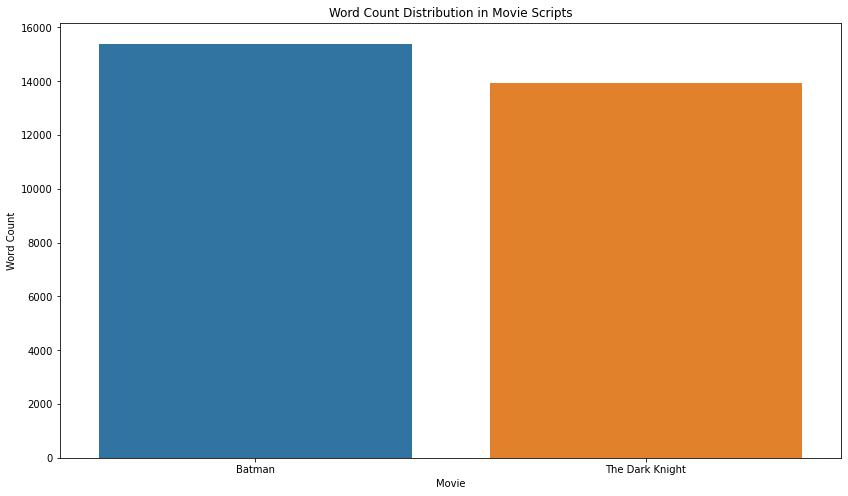

In [255]:
# Plot word count distribution for scripts
plt.figure(figsize=(14, 8))
sns.barplot(x=list(script_word_counts.keys()), y=list(script_word_counts.values()))
plt.title('Word Count Distribution in Movie Scripts')
plt.xlabel('Movie')
plt.ylabel('Word Count')
plt.show()

In [256]:
# Function to calculate word count and average word length
def calculate_statistics(text):
    # Tokenize the text
    words = text.split()
    # Calculate word count
    word_count = len(words)
    # Calculate total word length
    total_word_length = sum(len(word) for word in words)
    # Calculate average word length
    average_word_length = total_word_length / word_count if word_count > 0 else 0
    return word_count, average_word_length

# Create a new DataFrame to store the statistics
statistics_df = movie_df.copy()

# Apply the function to each row of the DataFrame
statistics_df['Word_Count'], statistics_df['Average_Word_Length'] = zip(*statistics_df['Preprocessed_Text'].apply(calculate_statistics))

statistics_df.head()

,Movie,Preprocessed_Text,Word_Count,Average_Word_Length
0,batman,batman screenplay hamm based character created...,15400,6.033052
1,the dark knight,dark knight jonathan nolan christopher nolan s...,13950,5.811541


In [257]:
# Calculate word counts for reviews
reviews_df['Word_Count'] = reviews_df['Cleaned_Review'].apply(lambda x: len(x.split()))

reviews_df.head()

,Movie,Review,Cleaned_Review,Tokenized_Text,Word_Count
0,batman,tim burton's batman is a gothic superhero movi...,tim burtons batman gothic superhero movie embr...,"[tim, burtons, batman, gothic, superhero, movi...",12
1,batman,"set to danny elfman’s triumphant score, burton...",set danny elfmans triumphant score burtons fir...,"[set, danny, elfmans, triumphant, score, burto...",19
2,batman,the result is a film that may please adults mo...,result film may please adults youngsters isnt ...,"[result, film, may, please, adults, youngsters...",8
3,batman,the gotham city created in batman is one of th...,gotham city created batman one distinctive atm...,"[gotham, city, created, batman, distinctive, a...",16
4,batman,"it is both a technical and aesthetic triumph, ...",technical aesthetic triumph fact made impressi...,"[technical, aesthetic, triumph, fact, made, im...",13


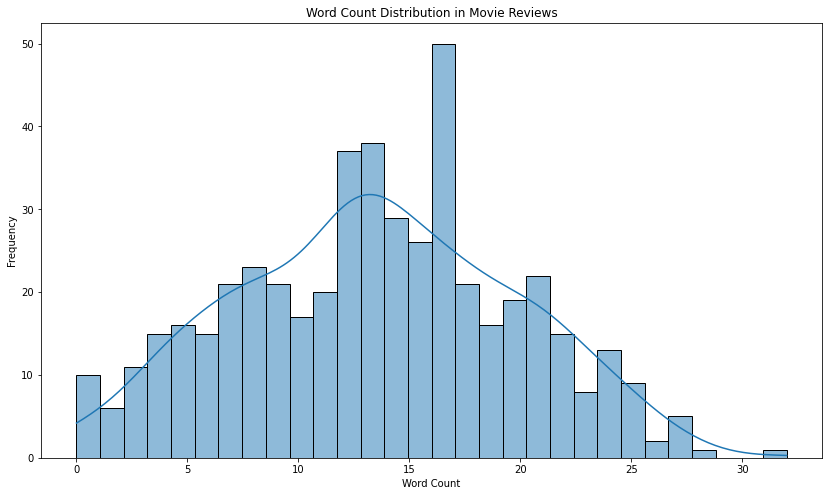

In [258]:
# Plot word count distribution for reviews
plt.figure(figsize=(14, 8))
sns.histplot(reviews_df['Word_Count'], bins=30, kde=True)
plt.title('Word Count Distribution in Movie Reviews')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

In [259]:
# Tokenize the cleaned review text into words and calculate word count
reviews_df['Word_Count'] = reviews_df['Cleaned_Review'].apply(lambda x: len(nltk.word_tokenize(x)))

# Group the data by movie and calculate total word count and average word length
review_stats_df = reviews_df.groupby('Movie').agg(
    Total_Word_Count=('Word_Count', 'sum'),
    Average_Word_Length=('Word_Count', lambda x: x.mean())
)

review_stats_df.head()

,Total_Word_Count,Average_Word_Length
Movie,,
batman,1826,13.042857
the dark knight,4741,13.662824


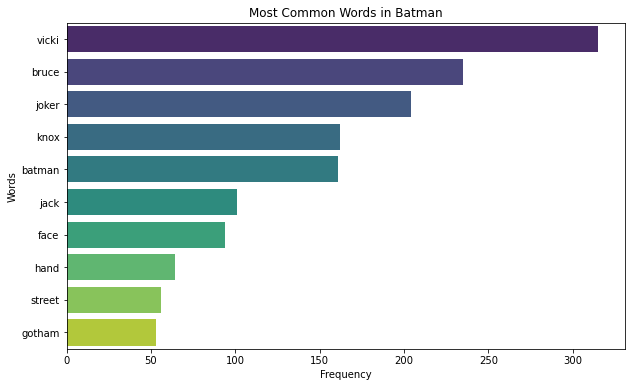

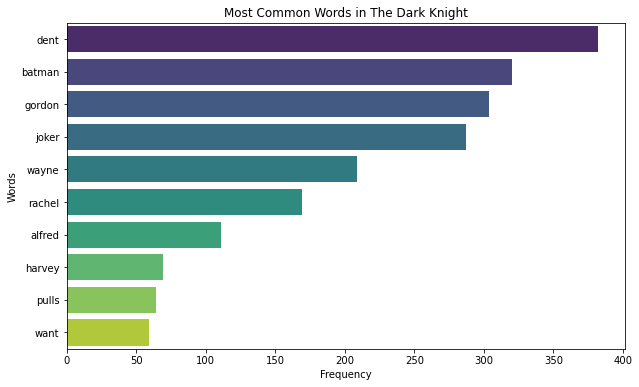

In [260]:
# Most common words in scripts
def plot_common_words(text_data, title):
    word_freq = Counter(text_data)
    common_words = word_freq.most_common(10)
    words, frequencies = zip(*common_words)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(frequencies), y=list(words), palette='viridis')
    plt.title(title)
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.show()

# Plot most common words for each script
for movie, tokens in preprocessed_scripts.items():
    plot_common_words(tokens, f'Most Common Words in {movie}')

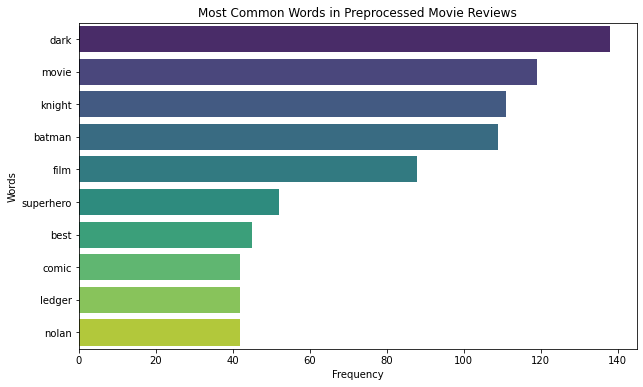

In [261]:
# Combine all tokenized texts
all_tokens = [token for sublist in reviews_df['Tokenized_Text'] for token in sublist]

# Count word frequencies
word_freq = Counter(all_tokens)

# Function to plot most common words
def plot_common_words(word_freq, title):
    common_words = word_freq.most_common(10)
    words, frequencies = zip(*common_words)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(frequencies), y=list(words), palette='viridis')
    plt.title(title)
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.show()

# Plot most common words in review_clean
plot_common_words(word_freq, 'Most Common Words in Preprocessed Movie Reviews')

In [262]:
# Calculate vocabulary richness for scripts
script_vocab_richness = {movie: len(set(tokens)) for movie, tokens in preprocessed_scripts.items()}

print(script_vocab_richness)

{'Batman': 5000, 'The Dark Knight': 3586}


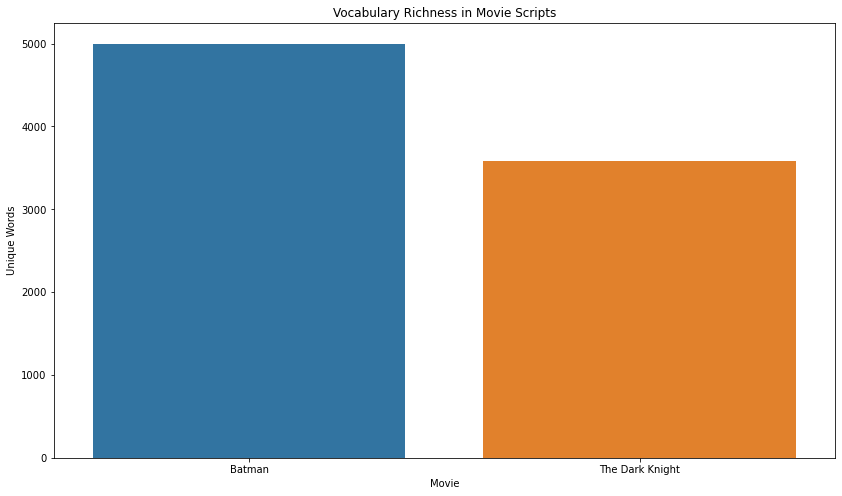

In [263]:
# Plot vocabulary richness for scripts
plt.figure(figsize=(14, 8))
sns.barplot(x=list(script_vocab_richness.keys()), y=list(script_vocab_richness.values()))
plt.title('Vocabulary Richness in Movie Scripts')
plt.xlabel('Movie')
plt.ylabel('Unique Words')
plt.show()

In [264]:
# Calculate vocabulary richness for reviews
reviews_df['Vocabulary_Richness'] = reviews_df['Cleaned_Review'].apply(lambda x: len(set(x.split())))

reviews_df.head()

,Movie,Review,Cleaned_Review,Tokenized_Text,Word_Count,Vocabulary_Richness
0,batman,tim burton's batman is a gothic superhero movi...,tim burtons batman gothic superhero movie embr...,"[tim, burtons, batman, gothic, superhero, movi...",12,12
1,batman,"set to danny elfman’s triumphant score, burton...",set danny elfmans triumphant score burtons fir...,"[set, danny, elfmans, triumphant, score, burto...",19,18
2,batman,the result is a film that may please adults mo...,result film may please adults youngsters isnt ...,"[result, film, may, please, adults, youngsters...",8,8
3,batman,the gotham city created in batman is one of th...,gotham city created batman one distinctive atm...,"[gotham, city, created, batman, distinctive, a...",16,16
4,batman,"it is both a technical and aesthetic triumph, ...",technical aesthetic triumph fact made impressi...,"[technical, aesthetic, triumph, fact, made, im...",13,13


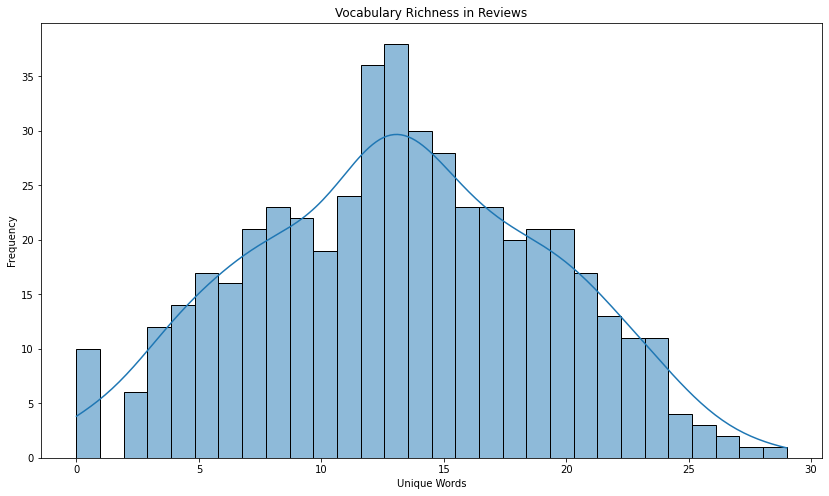

In [265]:
# Plot vocabulary richness for reviews
plt.figure(figsize=(14, 8))
sns.histplot(reviews_df['Vocabulary_Richness'], bins=30, kde=True)
plt.title('Vocabulary Richness in Reviews')
plt.xlabel('Unique Words')
plt.ylabel('Frequency')
plt.show()

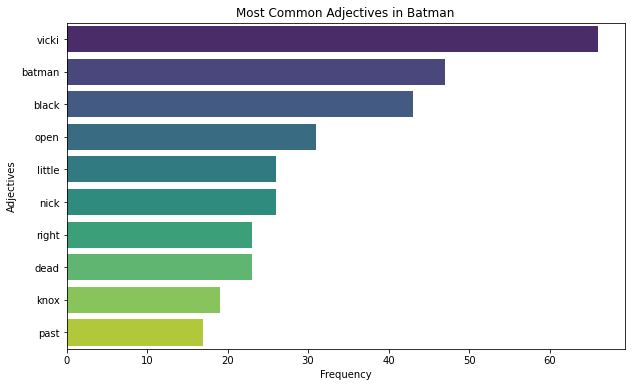

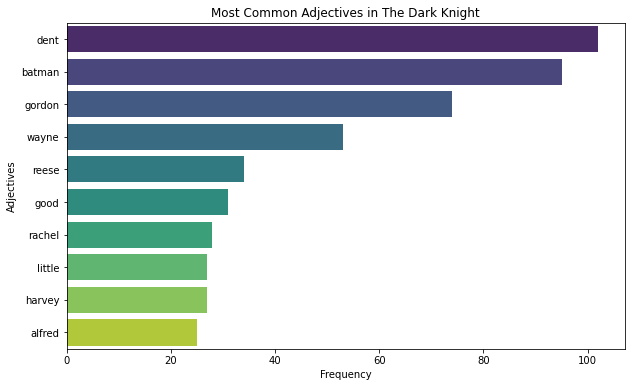

In [266]:
# Extract adjectives from scripts
def extract_adjectives(text):
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    adjectives = [word for word, pos in pos_tags if pos in ['JJ', 'JJR', 'JJS']]
    return adjectives

# Adjectives in scripts
script_adjectives = {movie: extract_adjectives(' '.join(tokens)) for movie, tokens in preprocessed_scripts.items()}


# Plot adjective frequency in scripts
for movie, adjectives in script_adjectives.items():
    adj_freq = Counter(adjectives)
    common_adjectives = adj_freq.most_common(10)
    words, frequencies = zip(*common_adjectives)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(frequencies), y=list(words), palette='viridis')
    plt.title(f'Most Common Adjectives in {movie}')
    plt.xlabel('Frequency')
    plt.ylabel('Adjectives')
    plt.show()

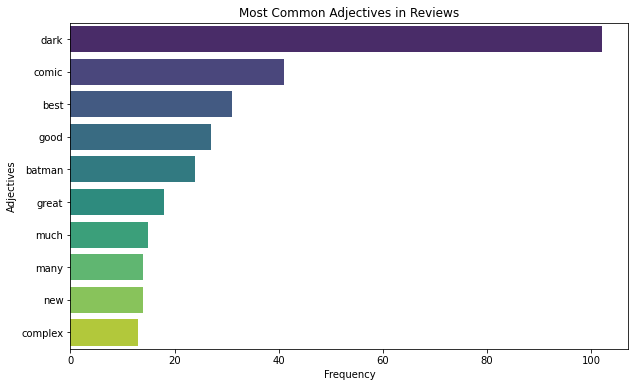

In [267]:
# Adjectives in reviews
review_adjectives = [extract_adjectives(review) for review in reviews_df['Cleaned_Review']]

# Combine adjectives from all reviews
all_review_adjectives = [adj for sublist in review_adjectives for adj in sublist]

# Plot adjective frequency in reviews
review_adj_freq = Counter(all_review_adjectives)
common_review_adjectives = review_adj_freq.most_common(10)
words, frequencies = zip(*common_review_adjectives)

plt.figure(figsize=(10, 6))
sns.barplot(x=list(frequencies), y=list(words), palette='viridis')
plt.title('Most Common Adjectives in Reviews')
plt.xlabel('Frequency')
plt.ylabel('Adjectives')
plt.show()

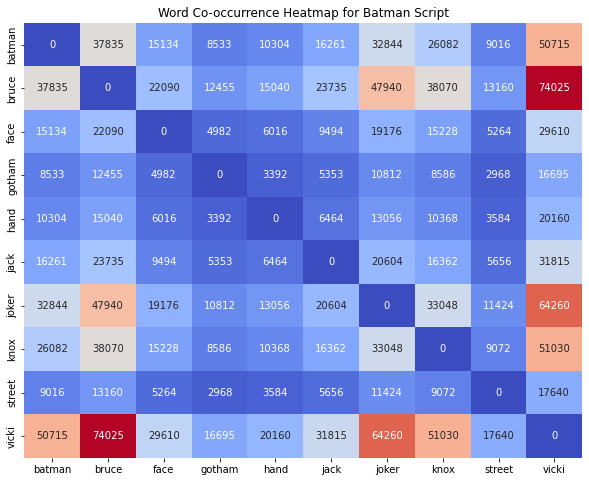

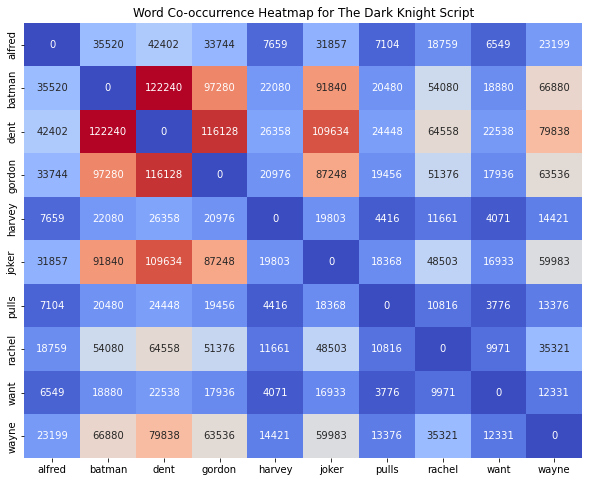

In [268]:
from sklearn.feature_extraction.text import CountVectorizer

# Function to create a co-occurrence matrix
def create_cooccurrence_matrix(tokens, top_n=10):
    vectorizer = CountVectorizer(max_features=top_n)
    X = vectorizer.fit_transform([' '.join(tokens)])
    Xc = (X.T * X)
    Xc.setdiag(0)
    return pd.DataFrame(Xc.toarray(), index=vectorizer.get_feature_names_out(), columns=vectorizer.get_feature_names_out())

# Plot heatmap of word co-occurrences
def plot_heatmap(matrix, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=True, cmap='coolwarm', cbar=False, fmt='g')
    plt.title(title)
    plt.show()

# Heatmap for movie scripts
for movie, tokens in preprocessed_scripts.items():
    matrix = create_cooccurrence_matrix(tokens)
    plot_heatmap(matrix, f'Word Co-occurrence Heatmap for {movie} Script')

In [ ]:
# Function to calculate sentiment for each dialogue
def calculate_sentiment(text):
    analysis = TextBlob(' '.join(text))
    return analysis.sentiment.polarity, analysis.sentiment.subjectivity

# Calculate sentiment for each movie script
preprocessed_df['Sentiment_Polarity'], preprocessed_df['Sentiment_Subjectivity'] = zip(*preprocessed_df['Preprocessed_Text'].apply(calculate_sentiment))

# Display the DataFrame with sentiment scores
preprocessed_df.head()

In [ ]:
# Function to plot sentiment analysis
def plot_sentiment_analysis(df, title, sentiment_col):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Movie', y=sentiment_col, data=df, palette='viridis')
    plt.title(title)
    plt.xlabel('Movie')
    plt.ylabel('Sentiment Score')
    plt.show()

# Plot sentiment polarity
plot_sentiment_analysis(preprocessed_df, 'Average Sentiment Polarity for Batman Movies', 'Sentiment_Polarity')

# Plot sentiment subjectivity
plot_sentiment_analysis(preprocessed_df, 'Average Sentiment Subjectivity for Batman Movies', 'Sentiment_Subjectivity')

Batman: Exhibits a slightly positive polarity and a moderately high subjectivity, indicating a balanced tone with some personal and opinionated elements.

The Dark Knight: Shows a more positive polarity and slightly lower subjectivity, indicating a more factual and objective tone but still with some positive sentiment.

In [ ]:
# Function to calculate sentiment over time
def sentiment_over_time(text):
    sentiment_data = []
    for i, word in enumerate(text):
        analysis = TextBlob(word)
        sentiment_data.append({'Word_Index': i, 'Sentiment_Polarity': analysis.sentiment.polarity})
    return pd.DataFrame(sentiment_data)

# Calculate sentiment over time for each movie
sentiment_over_time_data = {row['Movie']: sentiment_over_time(row['Preprocessed_Text']) for index, row in preprocessed_df.iterrows()}

# Plot sentiment over time for each movie
for movie, data in sentiment_over_time_data.items():
    plt.figure(figsize=(14, 8))
    sns.lineplot(x='Word_Index', y='Sentiment_Polarity', data=data, palette='viridis')
    plt.title(f'Sentiment Polarity Over Time in {movie}')
    plt.xlabel('Word Index')
    plt.ylabel('Sentiment Polarity')
    plt.show()

In [ ]:
# Function to calculate sentiment over time with aggregation
def sentiment_over_time(text, window_size=50):
    sentiment_data = []
    for i in range(0, len(text), window_size):
        window_text = text[i:i+window_size]
        if window_text:
            analysis = TextBlob(' '.join(window_text))
            sentiment_data.append({'Window_Index': i // window_size, 'Sentiment_Polarity': analysis.sentiment.polarity})
    return pd.DataFrame(sentiment_data)

# Calculate sentiment over time for each movie with a window size of 50
window_size = 50
sentiment_over_time_data = {row['Movie']: sentiment_over_time(row['Preprocessed_Text'], window_size) for index, row in preprocessed_df.iterrows()}

# Plot sentiment over time for each movie
def plot_sentiment_over_time(data, title):
    plt.figure(figsize=(14, 8))
    sns.lineplot(x='Window_Index', y='Sentiment_Polarity', data=data, marker='o', palette='viridis')
    plt.title(title)
    plt.xlabel('Window Index')
    plt.ylabel('Sentiment Polarity')
    plt.ylim(-1, 1)  # Set the y-axis limits for better readability
    plt.axhline(0, color='gray', linestyle='--')  # Add a horizontal line at y=0
    plt.show()

# Plot sentiment over time for each movie
for movie, data in sentiment_over_time_data.items():
    plot_sentiment_over_time(data, f'Sentiment Polarity Over Time in {movie}')


In [ ]:
# Determine the darker or more intense movie based on sentiment polarity
darker_movie = preprocessed_df.loc[preprocessed_df['Sentiment_Polarity'].idxmin()]['Movie']
print(f'The darker or more intense Batman movie based on sentiment polarity is: {darker_movie}')

# Determine the more subjective movie
more_subjective_movie = preprocessed_df.loc[preprocessed_df['Sentiment_Subjectivity'].idxmax()]['Movie']
print(f'The more subjective Batman movie based on sentiment subjectivity is: {more_subjective_movie}')

In [ ]:
# Function to calculate sentiment for each review
def calculate_sentiment(text):
    analysis = TextBlob(' '.join(text))
    return analysis.sentiment.polarity, analysis.sentiment.subjectivity

# Calculate sentiment for each review
reviews_df['Sentiment_Polarity'], reviews_df['Sentiment_Subjectivity'] = zip(*reviews_df['Tokenized_Text'].apply(calculate_sentiment))

# Display the DataFrame with sentiment scores
reviews_df.head()

In [ ]:
# Box Plot of Sentiment Polarity Distribution
plt.figure(figsize=(10, 6))
sns.boxplot(x='Movie', y='Sentiment_Polarity', data=reviews_df, palette='viridis')
plt.title('Box Plot of Sentiment Polarity Distribution in Reviews')
plt.xlabel('Movie')
plt.ylabel('Sentiment Polarity')
plt.show()


In [ ]:
# Remove outliers using IQR method
Q1 = reviews_df['Sentiment_Polarity'].quantile(0.25)
Q3 = reviews_df['Sentiment_Polarity'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
filtered_df = reviews_df[(reviews_df['Sentiment_Polarity'] >= lower_bound) & (reviews_df['Sentiment_Polarity'] <= upper_bound)]

# Box Plot of Sentiment Polarity Distribution without outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x='Movie', y='Sentiment_Polarity', data=filtered_df, palette='viridis')
plt.title('Box Plot of Sentiment Polarity Distribution in Reviews (Without Outliers)')
plt.xlabel('Movie')
plt.ylabel('Sentiment Polarity')
plt.show()

In [ ]:
# Calculate sentiment for cleaned reviews
reviews_df['Review_Sentiment_Polarity'] = reviews_df['Cleaned_Review'].apply(lambda x: TextBlob(x).sentiment.polarity)
reviews_df['Review_Sentiment_Subjectivity'] = reviews_df['Cleaned_Review'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# Calculate average sentiment polarity and subjectivity for each movie
average_review_sentiment = reviews_df.groupby('Movie')[['Review_Sentiment_Polarity', 'Review_Sentiment_Subjectivity']].mean().reset_index()

In [ ]:
#Violin Plot 
plt.figure(figsize=(10, 6))
sns.violinplot(x='Movie', y='Review_Sentiment_Subjectivity', data=reviews_df, palette='muted')
plt.title('Violin Plot of Review Sentiment Subjectivity')
plt.xlabel('Movie')
plt.ylabel('Sentiment Subjectivity')
plt.show()

In [ ]:
# Scatter Plot of Sentiment Polarity vs. Subjectivity
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Sentiment_Polarity', y='Sentiment_Subjectivity', hue='Movie', data=reviews_df, palette='viridis', s=100, alpha=0.6)
plt.title('Scatter Plot of Sentiment Polarity vs. Subjectivity in Reviews')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Sentiment Subjectivity')
plt.legend(title='Movie')
plt.show()

To determine which Batman movie is "darker" or "more intense," we can compare the average sentiment polarity scores. 
A lower average polarity score indicates a darker or more negative sentiment.

In [ ]:
# Calculate average sentiment polarity for each movie
average_sentiment = reviews_df.groupby('Movie')['Sentiment_Polarity'].mean().reset_index()
print(average_sentiment)

# Plot average sentiment polarity for each movie
plt.figure(figsize=(10, 6))
sns.barplot(x='Movie', y='Sentiment_Polarity', data=average_sentiment, palette='viridis')
plt.title('Average Sentiment Polarity in Reviews')
plt.xlabel('Movie')
plt.ylabel('Average Sentiment Polarity')
plt.show()


In [ ]:
# Calculate average sentiment polarity and subjectivity for each movie
average_sentiment = reviews_df.groupby('Movie')[['Sentiment_Polarity', 'Sentiment_Subjectivity']].mean().reset_index()

# Determine which movie is darker and more subjective
darker_movie = average_sentiment.loc[average_sentiment['Sentiment_Polarity'].idxmin(), 'Movie']
more_subjective_movie = average_sentiment.loc[average_sentiment['Sentiment_Subjectivity'].idxmax(), 'Movie']

print(f"The darker or more intense Batman movie based on sentiment polarity is: {darker_movie}")
print(f"The more subjective Batman movie based on sentiment subjectivity is: {more_subjective_movie}")

Batman
Polarity: Slightly higher positive sentiment.
Subjectivity: Slightly more subjective, indicating more personal and opinionated reviews.

The Dark Knight
Polarity: Slightly lower positive sentiment.
Subjectivity: Slightly more objective, indicating more factual reviews.

In [ ]:
movie_df.head()

In [ ]:
reviews_df.head()

In [ ]:
# Combine datasets
combined_df = pd.merge(movie_df, reviews_df, on='Movie')

combined_df.head()

In [ ]:
# Theme extraction
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Combine all text (script + reviews) for each movie
combined_df['Combined_Text'] = combined_df['Preprocessed_Text'] + ' ' + combined_df['Cleaned_Review']

# Vectorize text
vectorizer = CountVectorizer(stop_words='english')
text_matrix = vectorizer.fit_transform(combined_df['Combined_Text'])

# LDA to find themes
lda = LatentDirichletAllocation(n_components=2, random_state=42)
lda.fit(text_matrix)

# Display themes
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
feature_names = vectorizer.get_feature_names_out()
display_topics(lda, feature_names, no_top_words)

In [ ]:
# Calculate sentiment for combined text
def calculate_combined_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity, analysis.sentiment.subjectivity

combined_df['Combined_Sentiment_Polarity'], combined_df['Combined_Sentiment_Subjectivity'] = zip(*combined_df['Combined_Text'].apply(calculate_combined_sentiment))

# Aggregate sentiment by movie
movie_sentiments = combined_df.groupby('Movie')[['Combined_Sentiment_Polarity', 'Combined_Sentiment_Subjectivity']].mean().reset_index()

# Compare with review sentiment
review_sentiments = combined_df.groupby('Movie')[['Sentiment_Polarity', 'Sentiment_Subjectivity']].mean().reset_index()

# Display results
print("Movie Sentiment Analysis:")
print(movie_sentiments)
print("\nReview Sentiment Analysis:")
print(review_sentiments)

In [ ]:
# Box Plot of Sentiment Polarity Distribution
# Remove outliers
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

filtered_df = remove_outliers(combined_df, 'Combined_Sentiment_Polarity')

# Create box plot without outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x='Movie', y='Combined_Sentiment_Polarity', data=filtered_df, palette='viridis')
plt.title('Box Plot of Combined Sentiment Polarity Distribution (Without Outliers)')
plt.xlabel('Movie')
plt.ylabel('Sentiment Polarity')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Combined_Sentiment_Polarity', y='Combined_Sentiment_Subjectivity', hue='Movie', data=combined_df, palette='deep')
plt.title('Scatter Plot of Sentiment Polarity vs. Subjectivity')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Sentiment Subjectivity')
plt.legend(title='Movie')
plt.show()


In [ ]:
#Violin Plot of Sentiment Subjectivity
plt.figure(figsize=(10, 6))
sns.violinplot(x='Movie', y='Combined_Sentiment_Subjectivity', data=combined_df, palette='muted')
plt.title('Violin Plot of Sentiment Subjectivity')
plt.xlabel('Movie')
plt.ylabel('Sentiment Subjectivity')
plt.show()

In [ ]:
# Calculate sentiment for cleaned reviews
reviews_df['Review_Sentiment_Polarity'] = reviews_df['Cleaned_Review'].apply(lambda x: TextBlob(x).sentiment.polarity)
reviews_df['Review_Sentiment_Subjectivity'] = reviews_df['Cleaned_Review'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# Calculate average sentiment polarity and subjectivity for each movie
average_review_sentiment = reviews_df.groupby('Movie')[['Review_Sentiment_Polarity', 'Review_Sentiment_Subjectivity']].mean().reset_index()

In [ ]:
# Which one literally is "darker"

In [ ]:
# Define dark and variations
dark = ['dark', 'darker', 'darkest']

dark_variations = [
    'dark', 'darker', 'darkest', 'gloomy', 'shadow', 'shadows', 'shadowy',
    'dim', 'grim', 'bleak', 'murky', 'obscure', 'black', 'blackness',
    'night', 'nightmare', 'sinister', 'foreboding', 'eerie', 'dusky',
    'sullen', 'overcast', 'tenebrous', 'nebulous', 'somber', 'dismal',
    'crepuscular', 'shrouded', 'stygian', 'pitch-black', 'inky', 'midnight',
    'opaque', 'unlit', 'nocturnal', 'funereal', 'caliginous', 'pitch-dark',
    'murk', 'cloudy', 'dimmed', 'darkened', 'drab', 'mournful', 'depressing',
    'chilling', 'haunting', 'menacing', 'ominous', 'dire', 'dour',
    'brooding', 'moody', 'bleak', 'gothic', 'sepulchral', 'melancholy',
    'pensive', 'pale', 'ashy', 'ashen', 'lurid', 'glowering', 'sinister',
    'fearsome', 'threatening', 'terrifying', 'forbidding', 'ghostly',
    'fiendish', 'mystic', 'ghastly', 'macabre', 'sable', 'shadowed',
    'phantom', 'misty', 'foggy', 'hazy', 'dim', 'dank', 'murky', 'fog',
    'mist', 'veil', 'obscurity', 'darkling', 'dusk', 'ebony', 'dull',
    'shade', 'tarnished', 'somber', 'drear', 'funereal', 'pallid',
    'creepy', 'fearful', 'petrifying', 'spooky', 'brumal', 'cadaverous',
    'charcoal', 'delphian', 'eldritch', 'gory', 'grisly', 'gruesome',
    'horrid', 'loathsome', 'phantasmal', 'shady', 'shady', 'turbid',
    'tyrannical', 'uncanny', 'unearthly', 'wicked', 'evildoers','devil',
    'scare','scared'
]

In [ ]:
# Function to count variations of "dark" in movie scripts, including setting and stage details
def count_dark_variations(text, variations):
    text = text.lower()  # Convert text to lowercase
    count = sum(text.count(var) for var in variations)
    return count

# Count occurrences of dark in original movie scripts
dark_counts_original_scripts = {movie: count_dark_variations(script, dark) for movie, script in scripts.items()}

# Count occurrences of dark in original movie scripts
dark_var_counts_original_scripts = {movie: count_dark_variations(script, dark_variations) for movie, script in scripts.items()}

print(dark_counts_original_scripts)
print(dark_var_counts_original_scripts)

In [ ]:
# Count occurrences in each review and store in a new column
reviews_df['Dark_Count'] = reviews_df['Cleaned_Review'].apply(lambda x: count_dark_variations(x, dark))

# Count occurrences of dark variations in each review and store in a new column
reviews_df['Dark_Var_Count'] = reviews_df['Cleaned_Review'].apply(lambda x: count_dark_variations(x, dark_variations))

# Calculate the total count of dark or dark variations in reviews_df grouped by movie
dark_counts_movie_reviews = reviews_df.groupby('Movie')['Dark_Count'].sum().reset_index()
# Convert to dictionary
dark_counts_movie_reviews = dict(zip(dark_counts_movie_reviews['Movie'], dark_counts_movie_reviews['Dark_Count']))
# Capitalize movie titles in the movie reviews dictionaries
dark_counts_movie_reviews = {k.title(): v for k, v in dark_counts_movie_reviews.items()}

dark_var_counts_movie_reviews = reviews_df.groupby('Movie')['Dark_Var_Count'].sum().reset_index()
# Convert to dictionary
dark_var_counts_movie_reviews = dict(zip(dark_var_counts_movie_reviews['Movie'], dark_var_counts_movie_reviews['Dark_Var_Count']))
# Capitalize movie titles in the movie reviews dictionaries
dark_var_counts_movie_reviews = {k.title(): v for k, v in dark_var_counts_movie_reviews.items()}



print(dark_counts_movie_reviews)
print(dark_var_counts_movie_reviews)

In [ ]:
# Plotting "How 'Dark' is each Batman?"
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
fig.suptitle("How 'Dark' is each Batman?", fontsize=16)

# From the movie scripts
sns.barplot(ax=axes[0], x=list(dark_counts_original_scripts.keys()), y=list(dark_counts_original_scripts.values()))
axes[0].set_title("From the Movie Scripts")
axes[0].set_xlabel("Movie")
axes[0].set_ylabel("Count of 'Dark'")

# From the movie reviews
sns.barplot(ax=axes[1], x=list(dark_counts_movie_reviews.keys()), y=list(dark_counts_movie_reviews.values()))
axes[1].set_title("From the Movie Reviews")
axes[1].set_xlabel("Movie")

plt.show()

# Plotting "How 'Dark' (and variations) is each Batman?"
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
fig.suptitle("How 'Dark' (and its variations) is each Batman?", fontsize=16)

# From the movie scripts
sns.barplot(ax=axes[0], x=list(dark_var_counts_original_scripts.keys()), y=list(dark_var_counts_original_scripts.values()))
axes[0].set_title("From the Movie Scripts")
axes[0].set_xlabel("Movie")
axes[0].set_ylabel("Count of 'Dark' Variations")

# From the movie reviews
sns.barplot(ax=axes[1], x=list(dark_var_counts_movie_reviews.keys()), y=list(dark_var_counts_movie_reviews.values()))
axes[1].set_title("From the Movie Reviews")
axes[1].set_xlabel("Movie")

plt.show()